# STROKE PREDICTION CLASSIFIER

#### Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

#### Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

#### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

LINK: https://www.kaggle.com/competitions/playground-series-s3e2/overview

---
## LIBRARIES AND DATA IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

from scipy import stats
from scipy.stats import pointbiserialr, pearsonr, spearmanr
from scipy.stats import skew, kurtosis, anderson

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def outlier_fx(data, parameter):
    q1 = data[parameter].quantile(0.25)
    q3 = data[parameter].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    clean = data[(data[parameter] >= lower) & (data[parameter] <= upper)]
    return clean

In [ ]:
def cap_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR

            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

In [ ]:
def outlier_fx_grouped(data, parameter, groupby_col):
    frames = []
    for group, subset in data.groupby(groupby_col):
        q1 = subset[parameter].quantile(0.25)
        q3 = subset[parameter].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        subset_cleaned = subset[(subset[parameter] >= lower) & (subset[parameter] <= upper)]
        frames.append(subset_cleaned)
    return pd.concat(frames)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/bootcamp batch9/stroke clf/train_stroke.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


---
## EXPLORATORY DATA ANALYSIS

In [ ]:
data.drop(columns='id', inplace=True)

In [ ]:
data.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.3+ MB


In [ ]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


REMARKS: There were no NaN's inside the data, however we will clear out any unreasonable or input error suspected data such as 'Unknown' gender or adult people with very low/unsurviveable BMI.

In [ ]:
e = data.loc[(data['bmi'] <= 13), :]
e

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1953,Female,1.24,0,0,No,children,Rural,113.40,10.3,Unknown,0
2204,Female,5.00,0,0,No,children,Urban,82.81,12.8,Unknown,0
5092,Female,5.00,0,0,No,children,Urban,93.21,12.8,Unknown,0
5819,Male,1.64,0,0,No,children,Urban,56.21,12.3,Unknown,0
7779,Female,1.24,0,0,No,children,Urban,61.94,10.3,Unknown,0
9436,Female,4.00,0,0,No,children,Urban,107.25,10.3,Unknown,0
10781,Male,57.00,0,0,Yes,Private,Rural,90.54,12.2,Unknown,0
11717,Female,1.80,0,0,No,children,Rural,69.68,13.0,Unknown,0


In [ ]:
data = data[(data['gender'] == 'Male') | (data['gender'] == 'Female')]
data = data[~((data['age'] > 10) & (data['bmi'] < 13))]
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


REMARKS: Some features need to be encoded because they're categorical type, so we'll do Label Encoder for 'Gender', 'ever_married', 'Residence_type'. And one-hot-encoding for 'work_type', and 'smoking_status'

In [ ]:
le = LabelEncoder()
data_a = data.copy()

data['gender'] = le.fit_transform(data['gender'])
data['ever_married'] = le.fit_transform(data['ever_married'])
data['Residence_type'] = le.fit_transform(data['Residence_type'])
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,28.0,0,0,1,Private,1,79.53,31.1,never smoked,0
1,1,33.0,0,0,1,Private,0,78.44,23.9,formerly smoked,0
2,0,42.0,0,0,1,Private,0,103.00,40.3,Unknown,0
3,1,56.0,0,0,1,Private,1,64.87,28.8,never smoked,0
4,0,24.0,0,0,0,Private,0,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,0,22.0,0,0,0,Govt_job,1,72.63,19.5,never smoked,0
15300,0,46.0,1,0,1,Private,1,101.19,32.1,never smoked,0
15301,0,75.0,0,0,1,Self-employed,1,87.69,26.2,never smoked,0
15302,1,46.0,0,0,1,Private,0,101.13,22.5,Unknown,0


In [ ]:
data = pd.get_dummies(data, columns=['work_type','smoking_status'])
data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,28.0,0,0,1,1,79.53,31.1,0,False,False,True,False,False,False,False,True,False
1,1,33.0,0,0,1,0,78.44,23.9,0,False,False,True,False,False,False,True,False,False
2,0,42.0,0,0,1,0,103.00,40.3,0,False,False,True,False,False,True,False,False,False
3,1,56.0,0,0,1,1,64.87,28.8,0,False,False,True,False,False,False,False,True,False
4,0,24.0,0,0,0,0,73.36,28.8,0,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,0,22.0,0,0,0,1,72.63,19.5,0,True,False,False,False,False,False,False,True,False
15300,0,46.0,1,0,1,1,101.19,32.1,0,False,False,True,False,False,False,False,True,False
15301,0,75.0,0,0,1,1,87.69,26.2,0,False,False,False,True,False,False,False,True,False
15302,1,46.0,0,0,1,0,101.13,22.5,0,False,False,True,False,False,True,False,False,False


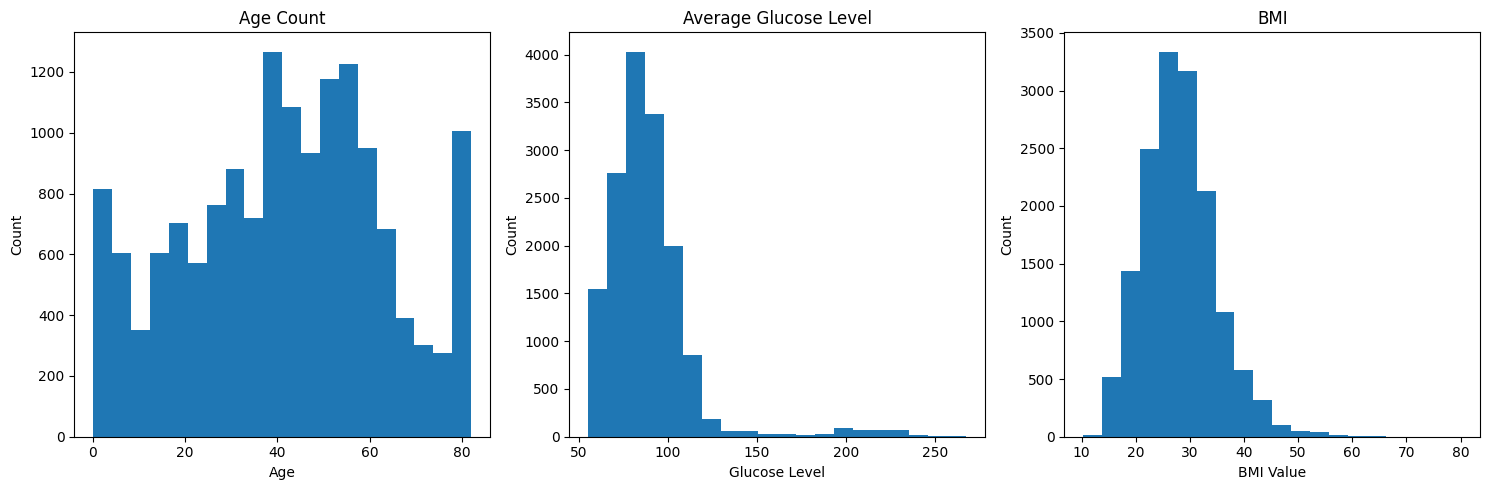

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(x=data['age'], bins=20)
plt.title('Age Count')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(132)
plt.hist(x=data['avg_glucose_level'], bins=20)
plt.title('Average Glucose Level')
plt.xlabel('Glucose Level')
plt.ylabel('Count')

plt.subplot(133)
plt.hist(x=data['bmi'], bins=20)
plt.title('BMI')
plt.xlabel('BMI Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# STATISTICS TEST FOR AGE FEATURE

print("Skewness:", skew(data['age']))
print("Kurtosis:", kurtosis(data['age']))

result = anderson(data['age'], dist='norm')  # 'norm' for normal distribution

print(f"Statistic: {result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level: Data looks normal (stat < critical value)")
    else:
        print(f"At {sl}% significance level: Data does NOT look normal (stat > critical value)")

dist_names = ['norm', 'expon', 'lognorm', 'gamma']
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(data['age'])
    print(f"{dist_name} params: {param}")

Skewness: -0.10354374535867915
Kurtosis: -0.8068273831178026
Statistic: 68.00525618746906
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level: Data does NOT look normal (stat > critical value)
At 10.0% significance level: Data does NOT look normal (stat > critical value)
At 5.0% significance level: Data does NOT look normal (stat > critical value)
At 2.5% significance level: Data does NOT look normal (stat > critical value)
At 1.0% significance level: Data does NOT look normal (stat > critical value)
norm params: (np.float64(41.41880799895439), np.float64(21.443402717519703))
expon params: (0.08, 41.338807998954394)
lognorm params: (np.float64(1.02248150773679e-05), -2097151.919999998, np.float64(2097193.33869837))
gamma params: (np.float64(759.8311904168752), np.float64(-550.8767528003846), np.float64(0.7794727389701134))


In [ ]:
# STATISTICS TEST FOR AVERAGE GLUCOSE LEVEL

print("Skewness:", skew(data['avg_glucose_level']))
print("Kurtosis:", kurtosis(data['avg_glucose_level']))

result = anderson(data['avg_glucose_level'], dist='norm')  # 'norm' for normal distribution

print(f"Statistic: {result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level: Data looks normal (stat < critical value)")
    else:
        print(f"At {sl}% significance level: Data does NOT look normal (stat > critical value)")

dist_names = ['norm', 'expon', 'lognorm', 'gamma']
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(data['avg_glucose_level'])
    print(f"{dist_name} params: {param}")

Skewness: 3.0368329121233963
Kurtosis: 13.170317967242092
Statistic: 750.069003947945
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level: Data does NOT look normal (stat > critical value)
At 10.0% significance level: Data does NOT look normal (stat > critical value)
At 5.0% significance level: Data does NOT look normal (stat > critical value)
At 2.5% significance level: Data does NOT look normal (stat > critical value)
At 1.0% significance level: Data does NOT look normal (stat > critical value)
norm params: (np.float64(89.03929747745393), np.float64(25.476868674461347))
expon params: (55.22, 33.81929747745393)
lognorm params: (np.float64(0.4634935217175607), 43.57375090103507, np.float64(40.60705610834008))
gamma params: (np.float64(2.610358050884079), np.float64(53.221581656376586), np.float64(13.72140005030866))


In [ ]:
# STATISTICS TEST FOR BMI

print("Skewness:", skew(data['bmi']))
print("Kurtosis:", kurtosis(data['bmi']))

result = anderson(data['bmi'], dist='norm')  # 'norm' for normal distribution

print(f"Statistic: {result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"At {sl}% significance level: Data looks normal (stat < critical value)")
    else:
        print(f"At {sl}% significance level: Data does NOT look normal (stat > critical value)")

dist_names = ['norm', 'expon', 'lognorm', 'gamma']
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(data['bmi'])
    print(f"{dist_name} params: {param}")

Skewness: 0.7138153248956632
Kurtosis: 1.3623598289471284
Statistic: 58.651014435699835
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level: Data does NOT look normal (stat > critical value)
At 10.0% significance level: Data does NOT look normal (stat > critical value)
At 5.0% significance level: Data does NOT look normal (stat > critical value)
At 2.5% significance level: Data does NOT look normal (stat > critical value)
At 1.0% significance level: Data does NOT look normal (stat > critical value)
norm params: (np.float64(28.114421644229513), np.float64(6.720806785835982))
expon params: (10.3, 17.814421644229512)
lognorm params: (np.float64(0.20456276711482868), -4.30537372019277, np.float64(31.747924021760305))
gamma params: (np.float64(11.354262601470163), np.float64(5.554082257227973), np.float64(1.9869491715432623))


REMARKS: Based on the visual plot above and statistic test, we can see that the 'age' feature doesn't have normal distribution and multimodal typed. The 'average glucose level' and 'bmi' value also not normally distributed and skewed. Therefore, tree based Machine Learning model would be used in this case.

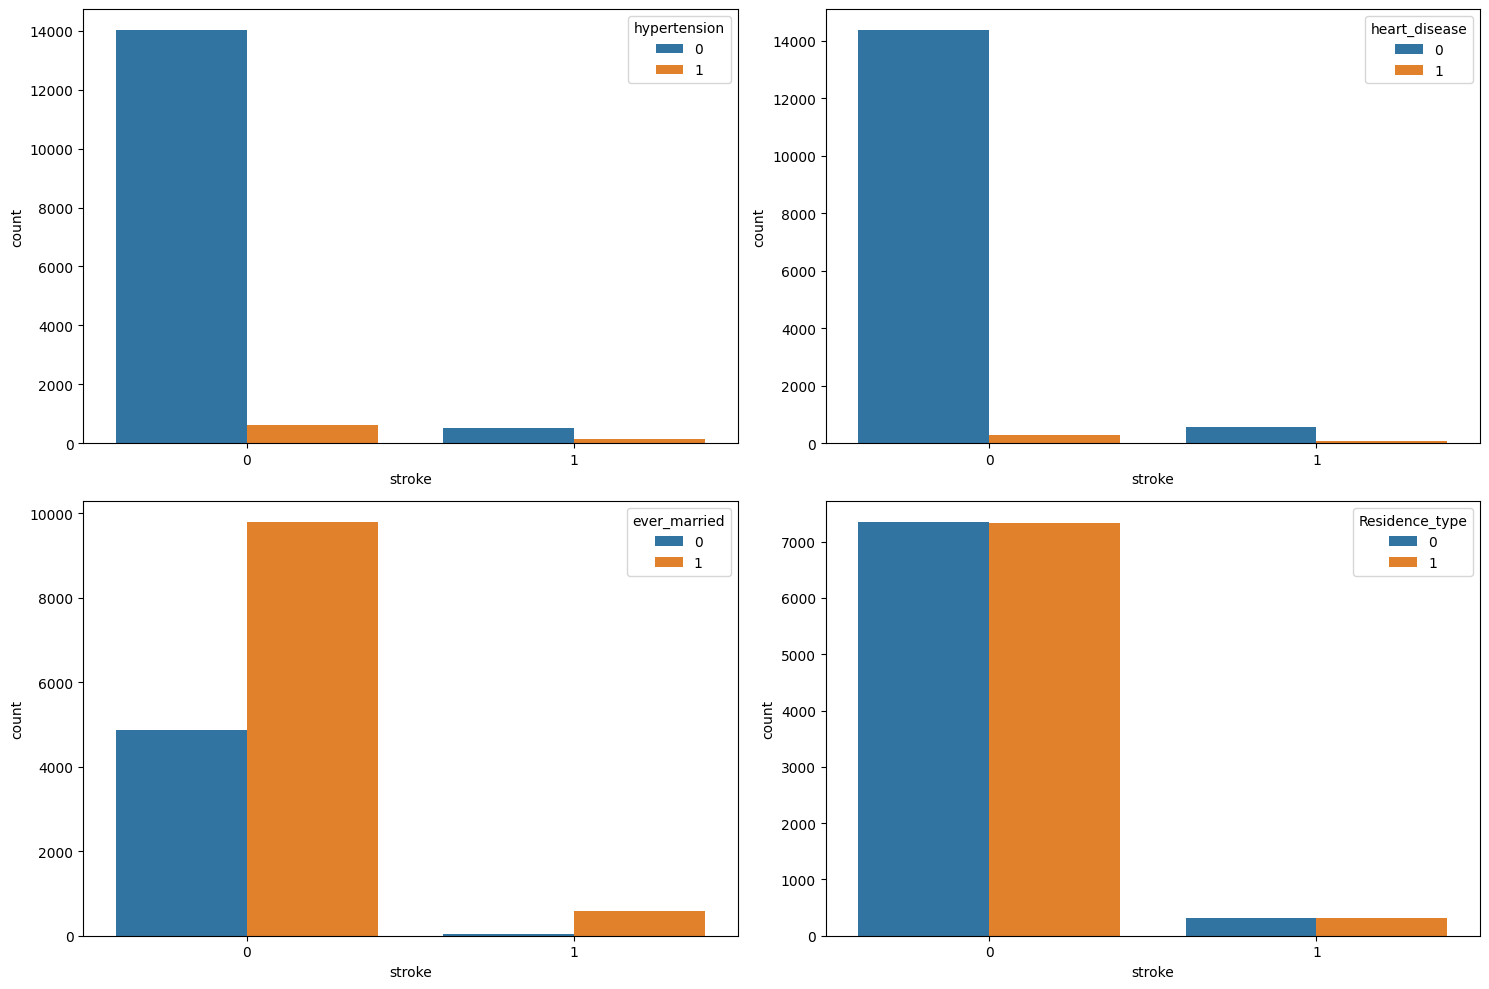

In [ ]:
a = data.groupby('stroke')['hypertension'].value_counts().reset_index(name='count')
b = data.groupby('stroke')['heart_disease'].value_counts().reset_index(name='count')
c = data.groupby('stroke')['ever_married'].value_counts().reset_index(name='count')
d = data.groupby('stroke')['Residence_type'].value_counts().reset_index(name='count')

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.barplot(x='stroke', y='count', hue='hypertension', data=a)

plt.subplot(222)
sns.barplot(x='stroke', y='count', hue='heart_disease', data=b)

plt.subplot(223)
sns.barplot(x='stroke', y='count', hue='ever_married', data=c)

plt.subplot(224)
sns.barplot(x='stroke', y='count', hue='Residence_type', data=d)
plt.tight_layout()
plt.show()

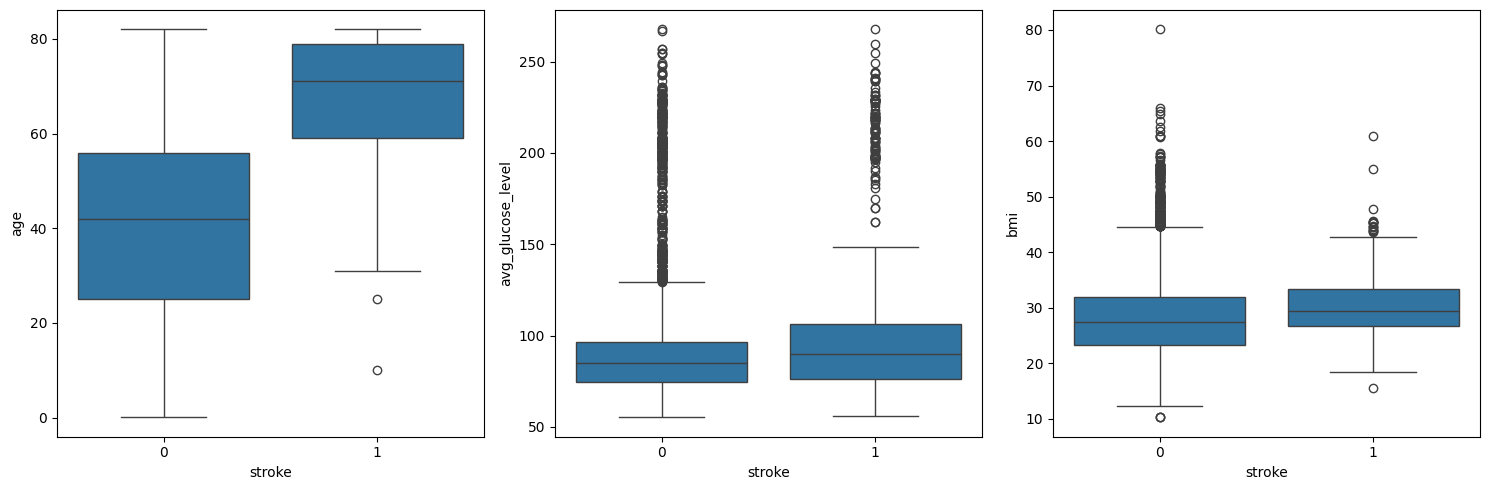

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(x=data['stroke'], y=data['age'])

plt.subplot(132)
sns.boxplot(x=data['stroke'], y=data['avg_glucose_level'])

plt.subplot(133)
sns.boxplot(x=data['stroke'], y=data['bmi'])
plt.tight_layout()
plt.show()

REMARKS: For the labeled encoder features, we can see that the proportions of people who got stroke is lower than people who are not in all features. Which is interesting, we shall see the correlations study after this. Boxplot also show some outliers in some features, therefore we'll try to capped them or delete them altogether, then we shall see what's the correlations value after that.

---
## EDA: CLEANING OUTLIERS AND FEATURES SELECTION

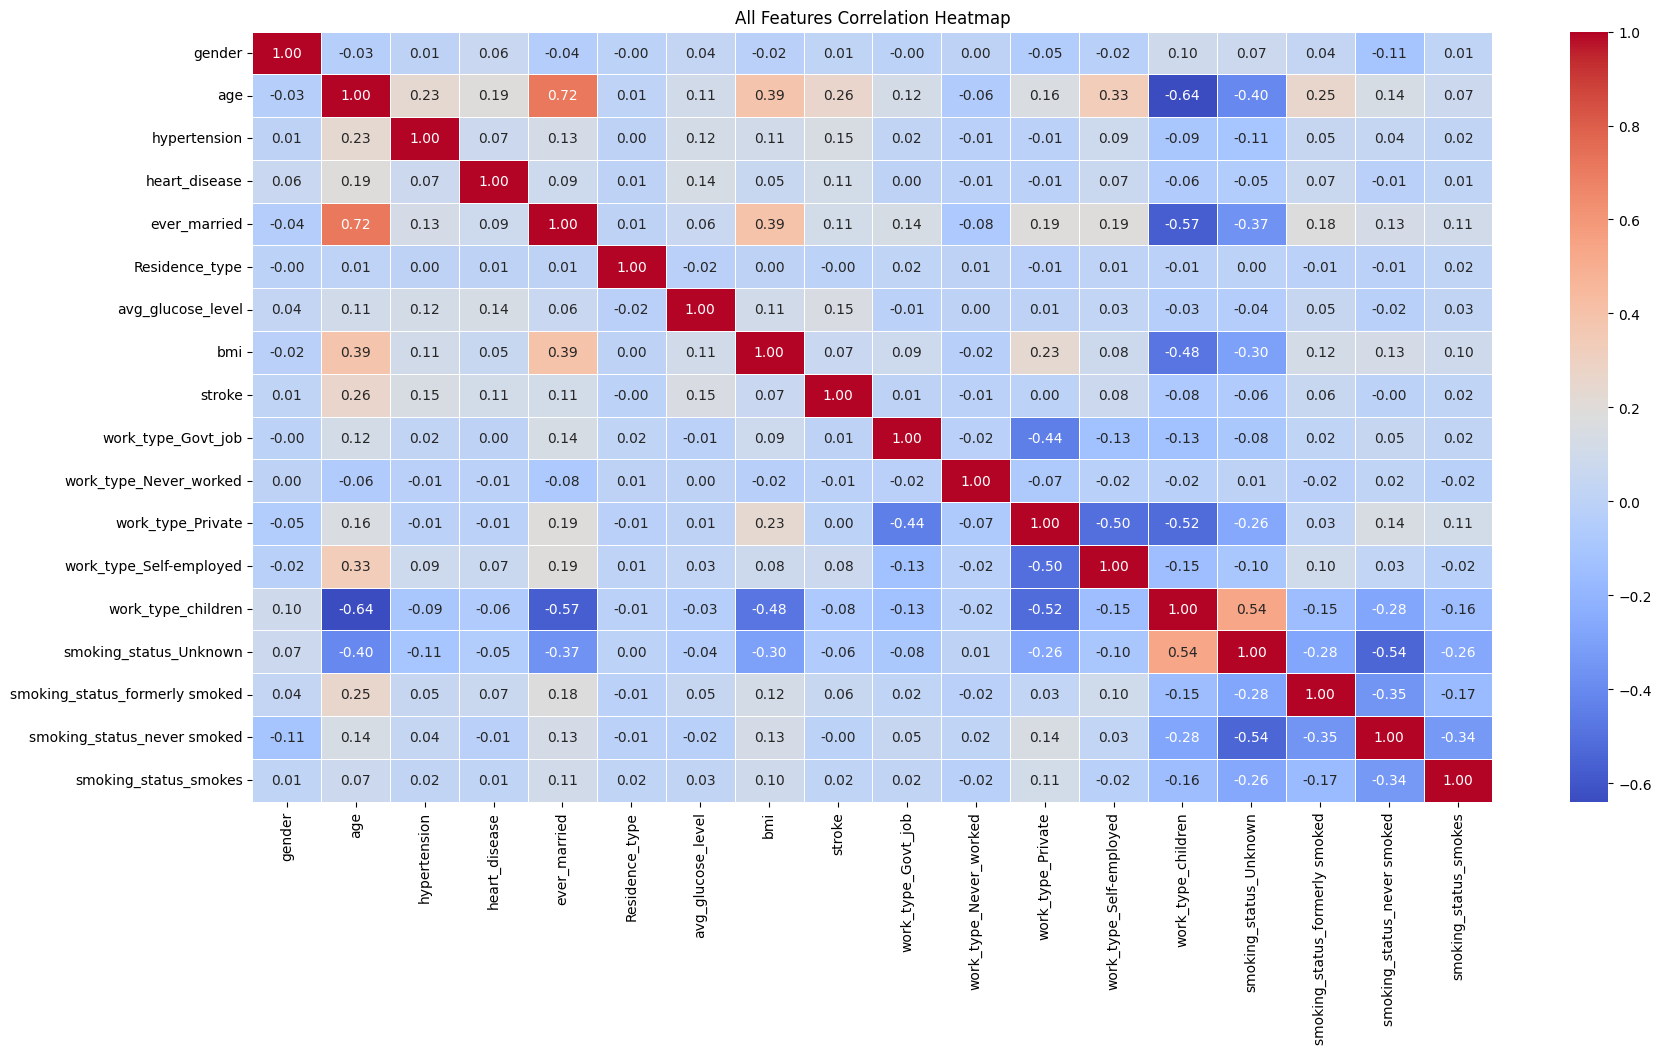

In [ ]:
# CORRELATIONS BEFORE OUTLIERS CLEANING AND FEATURE ENGINEERING
corr_matrix = data.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("All Features Correlation Heatmap")
plt.show()

In [ ]:
data = cap_outliers_iqr(data, columns=['age', 'avg_glucose_level', 'bmi'])
data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,28.0,0,0,1,1,79.53,31.1,0,False,False,True,False,False,False,False,True,False
1,1,33.0,0,0,1,0,78.44,23.9,0,False,False,True,False,False,False,True,False,False
2,0,42.0,0,0,1,0,103.00,40.3,0,False,False,True,False,False,True,False,False,False
3,1,56.0,0,0,1,1,64.87,28.8,0,False,False,True,False,False,False,False,True,False
4,0,24.0,0,0,0,0,73.36,28.8,0,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,0,22.0,0,0,0,1,72.63,19.5,0,True,False,False,False,False,False,False,True,False
15300,0,46.0,1,0,1,1,101.19,32.1,0,False,False,True,False,False,False,False,True,False
15301,0,75.0,0,0,1,1,87.69,26.2,0,False,False,False,True,False,False,False,True,False
15302,1,46.0,0,0,1,0,101.13,22.5,0,False,False,True,False,False,True,False,False,False


In [ ]:
# We'll do Feature Engineering to increase signal to target feature

data['stroke_risk_score'] = (
    0.3 * data['age'] +
    0.5 * data['bmi'] +
    1.5 * data['hypertension'] +
    2.0 * data['heart_disease'] +
    0.2 * data['avg_glucose_level']
)

In [ ]:
# features_main = ['age', 'avg_glucose_level', 'bmi']
# iso = IsolationForest(contamination=0.01, random_state=42)
# data['outlier_flag_main'] = iso.fit_predict(data[features_main])
# data

In [ ]:
# data = data.loc[(data['outlier_flag_main'] == 1), :]
# data

In [ ]:
# data = outlier_fx(data, 'avg_glucose_level')
# data

In [ ]:
# corr_matrix = data.corr(numeric_only=True)

# # Plot heatmap
# plt.figure(figsize=(20,10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("All Features Correlation Heatmap")
# plt.show()

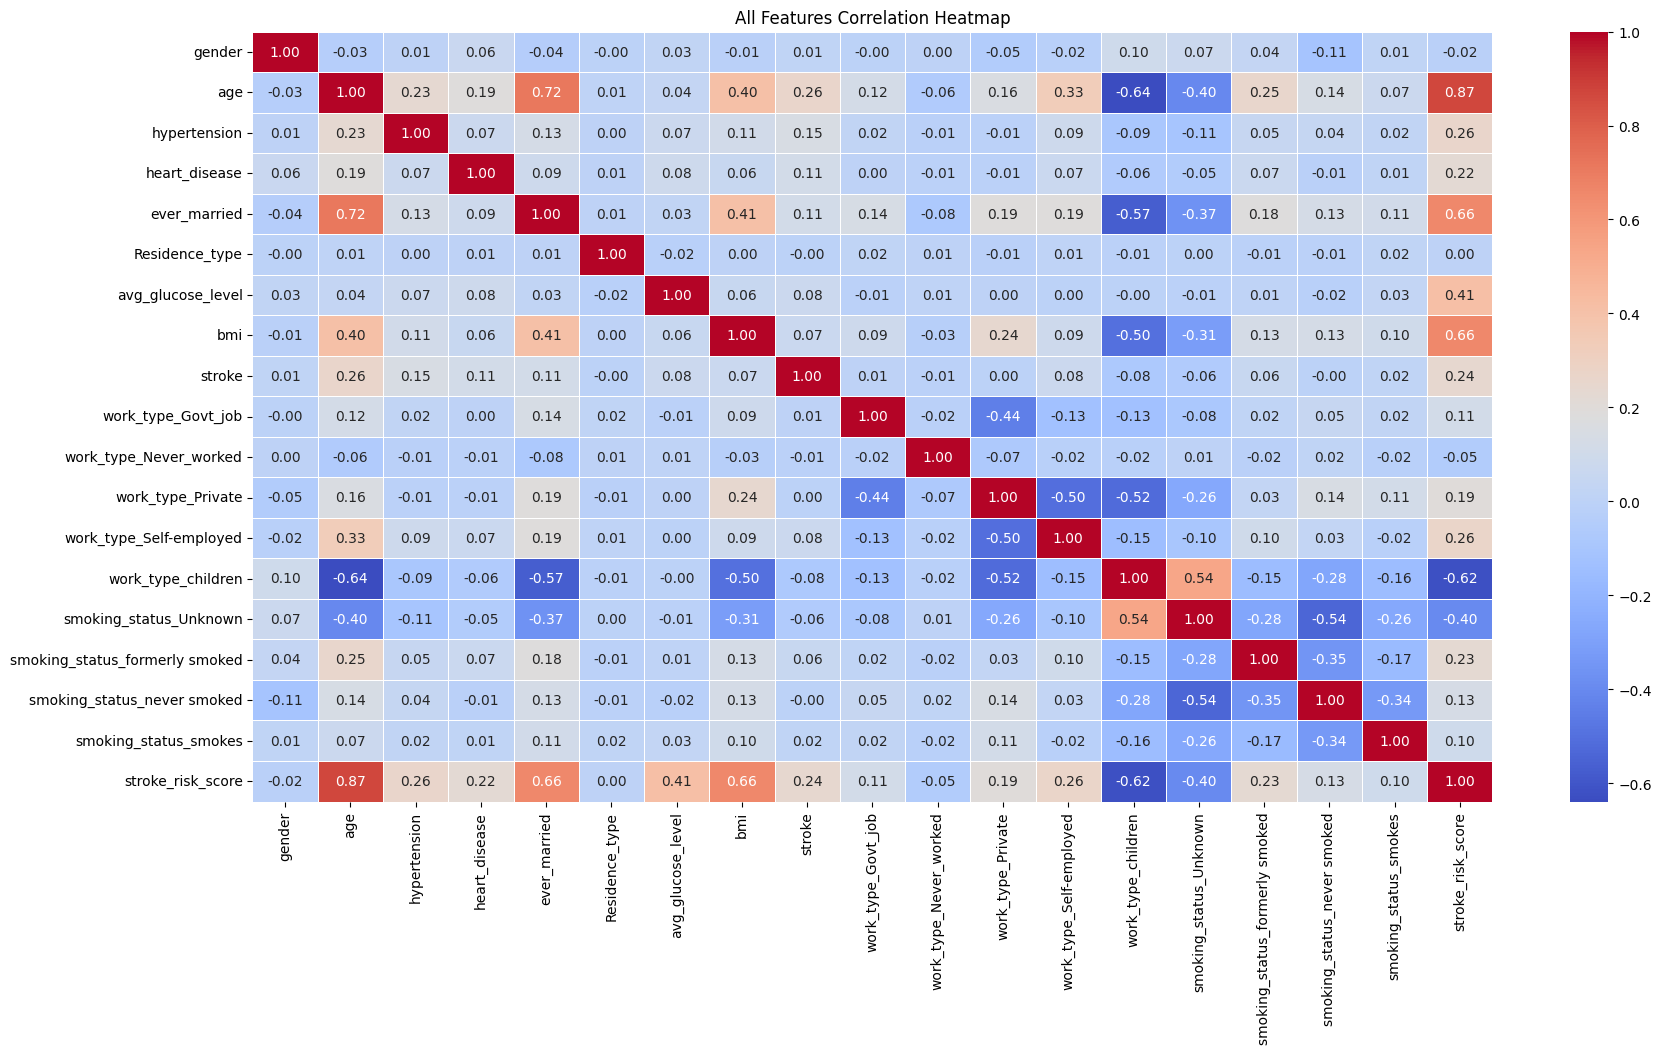

In [ ]:
corr_matrix = data.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("All Features Correlation Heatmap")
plt.show()

REMARKS: We have tried capping, deleting the outliers (either by per-features or grouped-features method) and found that capping will resulting better signal compared to deleting them. We'll then proceed to delete some low signal features to avoid noises.

In [ ]:
features = [col for col in data.columns if (col != 'stroke')]
y = data['stroke']

def correlation_vote_filter(X, y, threshold):
    # results = []
    cols_to_drop = []

    for col in X.select_dtypes(include='number').columns:
        try:
            pb, _ = pointbiserialr(X[col], y)
        except:
            pb = np.nan

        try:
            pr, _ = pearsonr(X[col], y)
        except:
            pr = np.nan

        try:
            sp, _ = spearmanr(X[col], y)
        except:
            sp = np.nan

        # Voting condition
        low_corr = all([
            abs(corr) <= threshold
            for corr in [pb, pr, sp]
            # for corr in [pr]
            if not np.isnan(corr)
        ])

        if low_corr:
            cols_to_drop.append(col)
    return cols_to_drop

corr_feat = correlation_vote_filter(data[features], y, threshold=0.05)
corr_feat

['gender', 'Residence_type']

In [ ]:
data.drop(columns=corr_feat, inplace=True)
addition = ['smoking_status_Unknown']
data.drop(columns=addition, inplace=True)
data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_risk_score
0,28.0,0,0,1,79.53,31.1,0,False,False,True,False,False,False,True,False,39.856
1,33.0,0,0,1,78.44,23.9,0,False,False,True,False,False,True,False,False,37.538
2,42.0,0,0,1,103.00,40.3,0,False,False,True,False,False,False,False,False,53.350
3,56.0,0,0,1,64.87,28.8,0,False,False,True,False,False,False,True,False,44.174
4,24.0,0,0,0,73.36,28.8,0,False,False,True,False,False,False,True,False,36.272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,22.0,0,0,0,72.63,19.5,0,True,False,False,False,False,False,True,False,30.876
15300,46.0,1,0,1,101.19,32.1,0,False,False,True,False,False,False,True,False,51.588
15301,75.0,0,0,1,87.69,26.2,0,False,False,False,True,False,False,True,False,53.138
15302,46.0,0,0,1,101.13,22.5,0,False,False,True,False,False,False,False,False,45.276


---
## MACHINE LEARNING MODELLING

We'll try with 3 tree based ML Models: `RandomForestClassifier`, `LGBMClassifier` and `XGBClassifier`. Then we'll determine which model is the best and then proceed to do `GridSearchCV` to optimize the model even further

In [ ]:
X_all = data.drop(columns='stroke')
y_all = data['stroke']

X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# clf_all = RandomForestClassifier(n_estimators=120, max_depth=25, random_state=42, verbose=2)
clf_all = LGBMClassifier(n_estimators=120, max_depth=25, random_state=42, verbosity=3)
# clf_all = XGBClassifier(n_estimators=120, max_depth=55, objective='binary:logistic', verbosity=3)
clf_all.fit(X_train_all, y_train_all)

y_pred_proba_all = clf_all.predict_proba(X_val_all)[:, 1]
roc_all = roc_auc_score(y_val_all, y_pred_proba_all)

print(f"ROC AUC (All Data): {roc_all:.5f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 503, number of negative: 11738
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.963851
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.282766
[LightGBM] [Debug] init for col-wise cost 0.000555 seconds, init for row-wise cost 0.001149 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 12241, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041091 -> initscore=-3.149997
[LightGBM] [Info] Start training from score -3.149997
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

In [ ]:
parameters = {
    'learning_rate': [0.001, 0.01],
    'class_weight': ['balanced'],
    'n_estimators':[120, 150]
}
model = LGBMClassifier(max_depth=25, random_state=42, verbosity=3)
grid_s = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_s.fit(X_train_all, y_train_all)
best_model = grid_s.best_estimator_
# y_proba = best_model.predict_proba(X_val_all)[:, 1]  # probability of positive class (label 1)

calibrated_model = CalibratedClassifierCV(
    estimator=best_model,
    method='sigmoid',
    cv='prefit'
)
calibrated_model.fit(X_train_all, y_train_all)
y_proba = calibrated_model.predict_proba(X_val_all)[:, 1]

roc_auc = roc_auc_score(y_val_all, y_proba)
print(f"ROC AUC (All Data): {roc_auc:.3f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 503, number of negative: 11738
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.963851
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.282766
[LightGBM] [Debug] init for col-wise cost 0.000313 seconds, init for row-wise cost 0.001148 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 12241, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[L

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


ROC AUC (All Data): 0.890


CONCLUSSION: The Machine Learning model to do Binary Classification for Stroke Detection had been successfully made. Data Cleaning method was done by capping the outliers and doing Feature Engineering to increase correlation signals between features and target feature. Tree based ML models were chosen due to abnormality in data distribution, and `LGBMClassifer` was proven to be best model in this case, and after some optimizing steps, the model managed to predict the target feature with AUC ROC score of 0.89